## Playing with Neural Data

In [2]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.style as style; style.use('ggplot')

## Neural data

The deepmind nature paper came with the following neural recording data of optogenetically-modified mouse VTA neurons from a variable-magnitude-reward task (see the paper).

It appears to be a list of **reversal point**, **assymetric scaling** pairs (one per neuron).

* **Reversal point**: The reward amount at which the neuron will switch from eliciing a negative response to a positive response. This is understood to have been be calibrated to a particular expectile of the distribution, after the animals learned the task. Reward magnitudes are in 'estimated utility space' (see paper, methods section).
* **Asymmetric scalings**: The relative magnitude of positive RPE signals and negative RPE signals, $\alpha_+ / (\alpha_+ + \alpha_-)$, estimated for each neuron from response data (by separately estimating the gradient of the response slope for different rewards above and below the reversal point).

In [3]:
# BEGIN DEEP MIND DATA DUMP
# Estimated reversal points and asymmetric scalings from neural recordings
var_mag_values = np.array([(0.14723085014789711, 0.0033614698516132471),
                            (0.28667599774228614, 0.021082047404663212),
                            (0.28748251623549403, 0.049914307764483815),
                            (0.92369323024116956, 0.24368197348648254),
                            (1.3480737534396756, 0.42196866227890156),
                            (1.4125829520026296, 0.2235311630494646),
                            (1.6045034820863808, 0.47702076606215371),
                            (1.7501708044381341, 0.29611582067273567),
                            (3.2848767728849375, 0.3618169272255663),
                            (3.5349203217064185, 0.44251699585808746),
                            (3.7255198380895553, 0.51354237852028162),
                            (4.0160347355202095, 0.29136286695651709),
                            (4.1701645396832827, 0.24596278464602545),
                            (4.3778473672540272, 0.3389597335165157),
                            (4.3819834616604236, 0.4109029572142629),
                            (4.4271922132492669, 0.54775816343621309),
                            (4.5687396324777776, 0.22381550301577841),
                            (4.7432185053035987, 0.98442343982467528),
                            (4.8867786789047276, 0.53931528154401065),
                            (5.1465509369647409, 0.41450775685564373),
                            (5.1545083160041001, 0.56729757738255948),
                            (5.3809271892982986, 0.58246691207675527),
                            (5.4864699584151664, 0.68976626445596256),
                            (5.5322519651782756, 0.34638864585759571),
                            (5.8339188805237727, 0.55480031389511075),
                            (6.2720723207776592, 0.55707650132171915),
                            (6.440584024346915, 0.66221660546254524),
                            (6.5887100296960242, 0.71219295412779748),
                            (6.6818030225629439, 0.65433601123932617),
                            (6.8779347387975447, 0.79852221439758531),
                            (7.8087442676123002, 0.75769015692609276),
                            (8.1264758131781729, 0.70370061384230076),
                            (9.1472582490193517, 0.73113239691022691),
                            (10.202846417424675, 0.63879297718190153),
                            (10.234208410480866, 0.66074850653214368),
                            (10.502672664775268, 0.68294063333022759),
                            (11.277139094915993, 0.7518787167727442),
                            (12.894339210279924, 0.80620103870695436),
                            (13.779164335318981, 0.67485657176374936),
                            (20.0, 0.95602078106395083)])
# END DEEP MIND DATA DUMP

Now, we know these concepts as '$\epsilon_\tau$' and '$\tau$', respectively. So, we have a list of expectiles and taus based on the hypothetical learned reward distribution.

Let's play!

In [6]:
neural_data = var_mag_values
neural_epss, neural_taus = neural_data.T

In [4]:
print("no. neurons:", len(neural_data))

no. neurons: 40


That's the same as in the paper 😅.

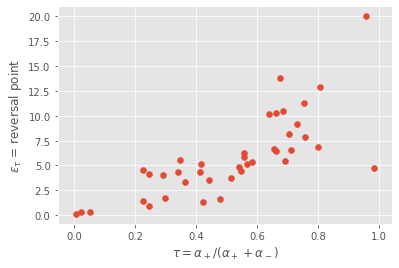

In [5]:
# The tau-expectile plot:
plt.scatter(neural_taus, neural_epss)
plt.ylabel(r"$\epsilon_\tau$ = reversal point")
plt.xlabel(r"$\tau = \alpha_+ / (\alpha_++\alpha_-)$")
plt.show()

Looks similar-*ish* to the plot in the paper (figure **4d**). However, they 1) included curves learned from the ground truth distribution in simulation, and 2) seem to have excluded the top point (it's quite high, and it showed an even higher error bar in figure **4c**).

## Diversity of expectiles

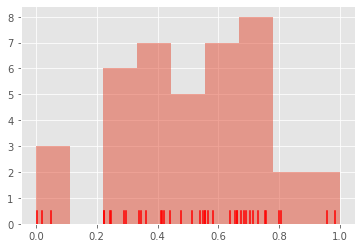

In [6]:
plt.hist(neural_taus, bins=np.linspace(0, 1, 10), alpha=0.5)
for tau in neural_taus:
    plt.plot([tau, tau], [0, 0.5], color="red")
plt.show()

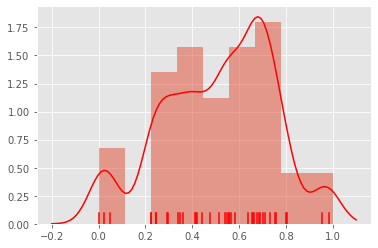

In [7]:
# same PLUS a gaussian-KDE-smoothed version:
plt.hist(neural_taus, bins=np.linspace(0, 1, 10), density=True, alpha=0.5)
for tau in neural_taus:
    plt.plot([tau, tau], [0, 0.1], color="red")
kde_dist = stats.gaussian_kde(neural_taus, bw_method=0.25)
support  = np.linspace(-0.2, 1.1, 100)
plt.plot(support, kde_dist.pdf(support), color="red", label="smoothed distribution (kde bw=0.2)")
plt.show()

Note: KDE probably not appropriate, given that the values are actually only supported over [0, 1] (as probabilities).

Anyway, I wonder where THIS distribution has come from? It doesn't look particularly clean: too centralised to be uniform (?), too spread to be Gaussian (?)

Note: you can't really tell what distribution a sample is from just by eyeballing it: do a statistical test! and for that, this is a very small sample.

What about the inverse logistic function of the biases? This might be sensibly distributed, since it corresponds to the biases arising according to the logistic function, which seems like a reasonable way to produce these asymmetries.

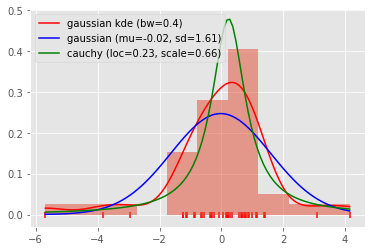

In [8]:
neural_logits = np.log(neural_taus / (1 - neural_taus))
plt.hist(neural_logits, density=True, alpha=0.5)
plt.scatter(neural_logits, np.zeros_like(neural_taus), color='red', marker='|')

# overlay some curves
support  = np.linspace(neural_logits.min(), neural_logits.max(), 100)

# gaussian kde
bw = 0.4
kde_dist = stats.gaussian_kde(neural_logits, bw_method=bw)
plt.plot(support, kde_dist.pdf(support), color="red", label=f"gaussian kde ({bw=})")

# single gaussian
norm_fit = stats.norm.fit(neural_logits)
norm_dist = stats.norm(*norm_fit)
plt.plot(support, norm_dist.pdf(support), color="blue",
         label="gaussian (mu={:.2f}, sd={:.2f})".format(*norm_fit))

# cauchy dist (heavy tails)
cauchy_fit = stats.cauchy.fit(neural_logits)
cauchy_dist = stats.cauchy(*cauchy_fit)
plt.plot(support, cauchy_dist.pdf(support), color="green",
         label="cauchy (loc={:.2f}, scale={:.2f})".format(*cauchy_fit))

plt.legend()
plt.show()

Neither of these (cauchy, gaussian) looks like a particularly great fit. Maybe some statistical tests could make that claim more rigorous. But this would imply that the balances are/are-not distributed in these ways.

### Recovering the distribution

How does this distribution go for OUR sample/reward distribution?

In [9]:
# compute_and_impute(taus=neural_taus)

Answer: Spot on! Nails it. However, fewer expectiles probaly would have done the trick too. Come to think of it, there are obviously more than 40 RPE-learning + signaling neurons in a brain. So, it's really just the distribution which matters.